In [158]:
%matplotlib inline
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from mueller_matrices import M_Retarder, M_Diattenuator, M_rotate, M_LinearPolarizer

In [259]:
def plotImages(I0, I1, I2, I3):
    fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

    ax1 = fig1.add_subplot(2,2,1) 
    im=plt.imshow(I0, cmap='gray')
    ax1.figure.colorbar(im)

    ax2=fig1.add_subplot(2,2,2)
    im=plt.imshow(I1, cmap='gray')
    ax2.figure.colorbar(im)

    ax3=fig1.add_subplot(2,2,3)
    im=plt.imshow(I2, cmap='gray')
    ax3.figure.colorbar(im)

    ax4=fig1.add_subplot(2,2,4)
    im=plt.imshow(I3, cmap='gray')
    ax4.figure.colorbar(im)

## Define symbolic parameters

In [2]:
S = sp.Matrix(sp.symbols('s0:4'))
s0, s1, s2, s3 = sp.symbols('s0, s1, s2, s3')
x, eps, eps2, theta = sp.symbols('x, eps, eps2, theta')
Tmax, Tmin = sp.symbols('Tmax, Tmin')
Tmax_0, Tmin_0 = sp.symbols('Tmax_0, Tmin_0')
Tmax_90, Tmin_90 = sp.symbols('Tmax_90, Tmin_90')
tx, ty, rx, ry = sp.symbols('tx, ty, rx, ry')
t90, t45, t135 = sp.symbols('t90, t45, t135')
delta = sp.symbols('delta')

## Model for 0 and 90 deg polarizers

In [3]:
# Max and min transmission of the two polarizers
Tmax_0 = 0.9718; Tmin_0 = 6.4E-4;
Tmax_90 = 0.9681; Tmin_90 = 6.3E-4;

M0_polarizer = M_Diattenuator(0, Tmax_0, Tmin_0)
M90_polarizer = M_Diattenuator(sp.pi/2, Tmax_90, Tmin_90)

M0_polarizer_ideal = M_Diattenuator(0, 1, 0)
M90_polarizer_ideal = M_Diattenuator(sp.pi/2, 1, 0)

## Model for 50/50 splitter

Splitter is modelled as a linear diattenuator, which transmits or reflects 50% of the incident light. Non-ideal performance is given by unequal transmission/reflection of s- and p-polarized light

In [4]:
# Transmission and reflection coefficients along two orthogonal coordinates
tx = 0.5321; ty = 0.4430;
rx = 0.4080; ry = 0.5091;

M5050_transmission = M_Diattenuator(0, tx, ty)
M5050_reflection = M_Diattenuator(0, rx, ry)

M5050_ideal = M_Diattenuator(0, 0.5, 0.5)

## Model for half-waveplate in 45/135 paths

In [5]:
# Orientation and retardance of the HWP
# HWP is oriented at -22.5 deg in current implementation
hwp_theta = -0.3592; hwp_delta = 3.0604;

M_HWP = M_Retarder(hwp_theta, hwp_delta)
M_HWP_ideal = M_Retarder(-sp.pi/8, sp.pi)

## Transmission coefficients of the 45/90/135 paths

In [6]:
t45 = 1.0056; t90 = 0.8720; t135 = 0.8174;

## Mueller matrices for the four paths

In [7]:
M0 = M0_polarizer * M5050_transmission
M90 = t90 * M90_polarizer * M5050_transmission
M45 = t45 * M_Diattenuator(0, 1, 0) * M_HWP * M5050_reflection # Linear polarizer is modeled as ideal
M135 = t135 * M_Diattenuator(sp.pi/2, 1, 0) * M_HWP * M5050_reflection # Linear polarizer is modeled as ideal

M0_ideal = M0_polarizer_ideal * M5050_ideal
M90_ideal = M90_polarizer_ideal * M5050_ideal
M45_ideal = M_Diattenuator(0, 1, 0) * M_HWP_ideal * M5050_ideal
M135_ideal = M_Diattenuator(sp.pi/2, 1, 0) * M_HWP_ideal * M5050_ideal

## Instrument matrix and inverse instrument matrix

* I = A * S

* S = Ainv * I

In [44]:
A = np.matrix([M0[0,:], M45[0,:], M90[0,:], M135[0,:],], dtype='float')
A_ideal = np.matrix([M0_ideal[0,:], M45_ideal[0,:], M90_ideal[0,:], M135_ideal[0,:],], dtype='float')

A_inv = np.linalg.pinv(A)
A_inv_ideal = np.linalg.pinv(A_ideal)

A_fit = np.matrix([[0.2642, 0.2600, 0.0011, 0],
                   [0.2282, 0.0058, -0.2258, 0],
                   [0.1845, -0.1876, -0.0005, 0],
                   [0.1909, -0.0460, 0.1846, 0]])
A_fit_inv = np.linalg.pinv(A_fit)

## Model of light source and sample

In [15]:
S_rcp = np.array([[1, 0, 0, 1]]).T
S_unp = np.array([[1, 0, 0, 0]]).T

t, p, phi = sp.symbols('t, p, phi')
M_tp = sp.Matrix([[t, 0, 0, 0], [0, t*p, 0, 0], [0, 0, t*p, 0], [0, 0, 0, t*p]])
M_sample = M_tp * M_Retarder(phi - sp.pi/2, delta)
S_sample = M_sample * S_rcp
print (S_sample)

Matrix([[t], [p*t*sin(delta)*sin(2*phi)], [-p*t*sin(delta)*cos(2*phi)], [p*t*cos(delta)]])


In [51]:
I_out1 = A * S_rcp
I_out2 = A_fit * S_rcp

print(I_out1 / I_out1[0] )
print(I_out2 / I_out2[0])

[[1.        ]
 [0.92527857]
 [0.72338842]
 [0.69680481]]
[[1.        ]
 [0.86373959]
 [0.6983346 ]
 [0.72255867]]


## No background

In [90]:
I_bg = A_fit * S_rcp
I_sample = A_fit * M_sample * S_rcp

S_bg = A_fit_inv * I_bg
S_sample = A_fit_inv * I_sample

print(S_sample)

Matrix([[-1.04083408558608e-16*p*t*sin(delta)*sin(2*phi) - 1.38777878078145e-16*p*t*sin(delta)*cos(2*phi) + 0.999999999999999*t], [1.0*p*t*sin(delta)*sin(2*phi) - 2.77555756156289e-17*p*t*sin(delta)*cos(2*phi) - 2.4980018054066e-16*t], [-2.91433543964104e-16*p*t*sin(delta)*sin(2*phi) - 1.0*p*t*sin(delta)*cos(2*phi) - 2.22044604925031e-16*t], [0]])


## Instrument background that can be calibrated

In [84]:
M_noise = M_Retarder(0.15, 0.1)

M0_noise = M0*M_noise
M45_noise = M45*M_noise
M90_noise = M90*M_noise
M135_noise = M135*M_noise

A_noise = np.matrix([M0_noise[0,:], M45_noise[0,:], M90_noise[0,:], M135_noise[0,:],], dtype='float')
A_noise_inv = np.linalg.pinv(A_noise)

I_bg2 = A_noise * S_rcp
I_sample2 = A_noise * M_sample * S_rcp

S_bg2 = A_fit_inv * I_bg2
S_sample2 = A_noise_inv * I_sample2

print(S_sample2)

Matrix([[-1.73472347597681e-16*p*t*sin(delta)*sin(2*phi) + 1.73472347597681e-18*p*t*cos(delta) + 1.0*t], [0.999127628736388*p*t*sin(delta)*sin(2*phi) - 0.00122891696159512*p*t*sin(delta)*cos(2*phi) - 0.029497457434353*p*t*cos(delta) + 8.32667268468867e-17*t], [0.00122891696159502*p*t*sin(delta)*sin(2*phi) - 0.998268814022777*p*t*sin(delta)*cos(2*phi) + 0.0415533239998516*p*t*cos(delta)], [-0.0294974574343527*p*t*sin(delta)*sin(2*phi) - 0.0415533239998522*p*t*sin(delta)*cos(2*phi) + 0.00260355724083443*p*t*cos(delta) + 3.46944695195361e-18*t]])


## Dust

In [249]:
w = 200; h = 200
xx, yy = np.meshgrid(range(w),range(h))
I_sample = A * S_rcp

n1 = 10 #number of dust spots
x1 = np.random.randint(0, high = w, size=n1)
y1 = np.random.randint(0, high = h, size=n1)
i1 = np.random.uniform(low=0.2, high=1.0, size = n1)
s1 = np.random.randint(1, high=10, size=n1)

n2 = 8
x2 = np.random.randint(0, high = w, size=n2)
y2 = np.random.randint(0, high = h, size=n2)
i2 = np.random.uniform(low=0.2, high=1.0, size = n2)
s2 = np.random.randint(1, high=10, size=n2)

# Calibration
S_in = np.array([M_LinearPolarizer(t) * S_unp for t in np.linspace(0, 2*np.pi, num=11)], dtype='float').T
I_base = A @ S_in
I_full = np.tile(np.array(I_base[None,None,:,:]), (w,h,1,1))

# I0 = np.ones((w,h), dtype='float') * np.asscalar(I_sample[0]) * 4000*2
# I45 = np.ones((w,h), dtype='float') * np.asscalar(I_sample[1]) * 4000*2
# I90 = np.ones((w,h), dtype='float') * np.asscalar(I_sample[2]) * 4000*2
# I135 = np.ones((w,h), dtype='float') * np.asscalar(I_sample[3]) * 4000*2

for i in range(n1):
    xx = slice(np.maximum(0,x1[i]-s1[i]), np.minimum(w-1,x1[i]+s1[i]))
    yy = slice(np.maximum(0,y1[i]-s1[i]), np.minimum(h-1,y1[i]+s1[i]))
#     I0[xx, yy] *= i1[i]
    I_full[xx,yy,0,:] *= i1[i]
    
for i in range(n2):
    xx = slice(np.maximum(0,x2[i]-s2[i]), np.minimum(w-1,x2[i]+s2[i]))
    yy = slice(np.maximum(0,y2[i]-s2[i]), np.minimum(h-1,y2[i]+s2[i]))
#     I135[xx, yy] *= i2[i]
    I_full[xx,yy,3,:] *= i2[i]

A_img = np.zeros((w,h,4,4), dtype='float')
for i in range(w):
    for j in range(h):
        A_img[i,j,:,:] = np.transpose(np.linalg.lstsq(S_in.T, I_full[i,j,:,:].T)[0])

/Users/ivan.ivanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


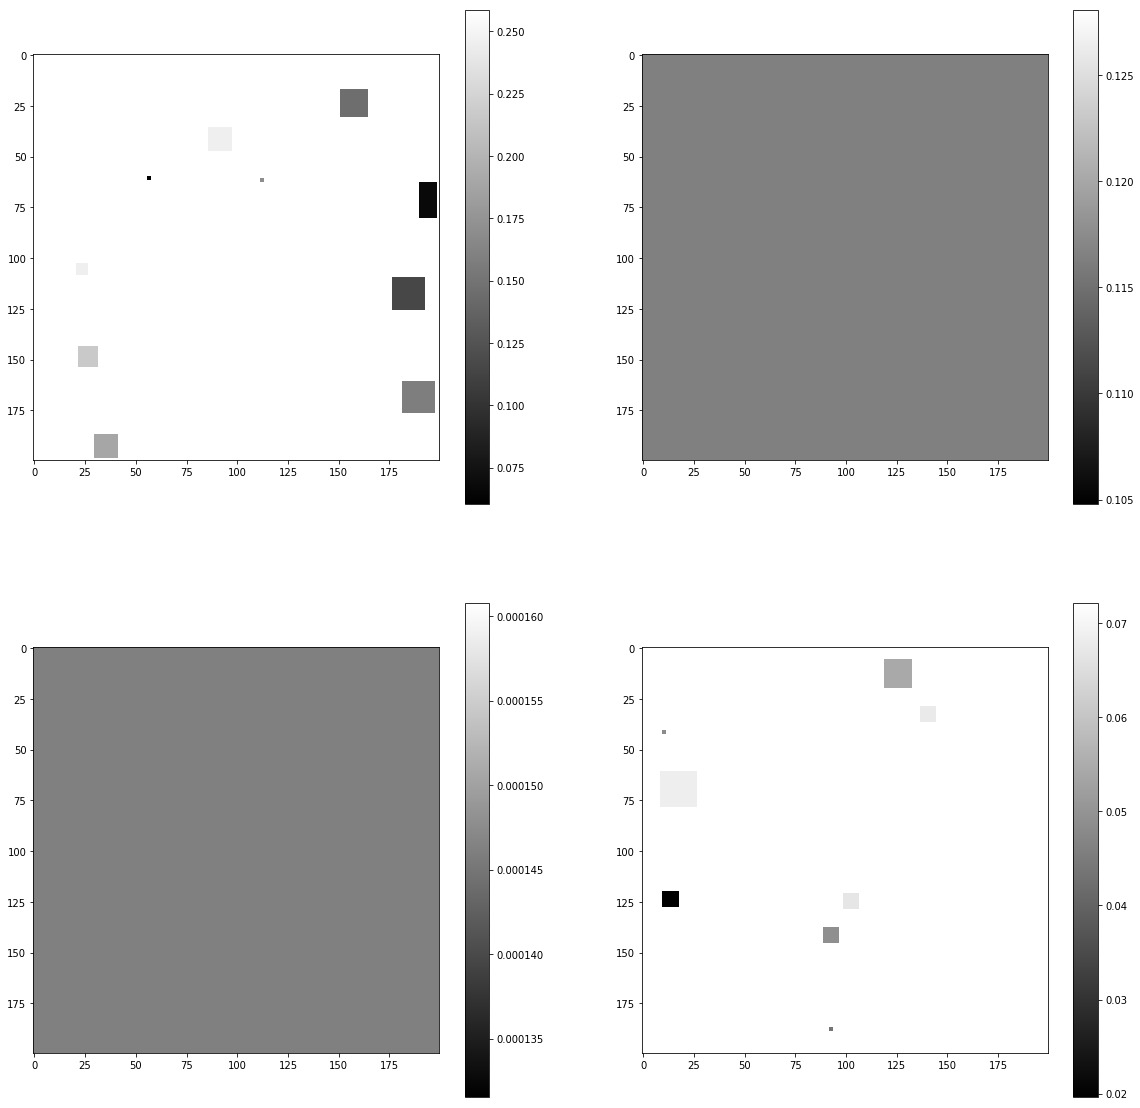

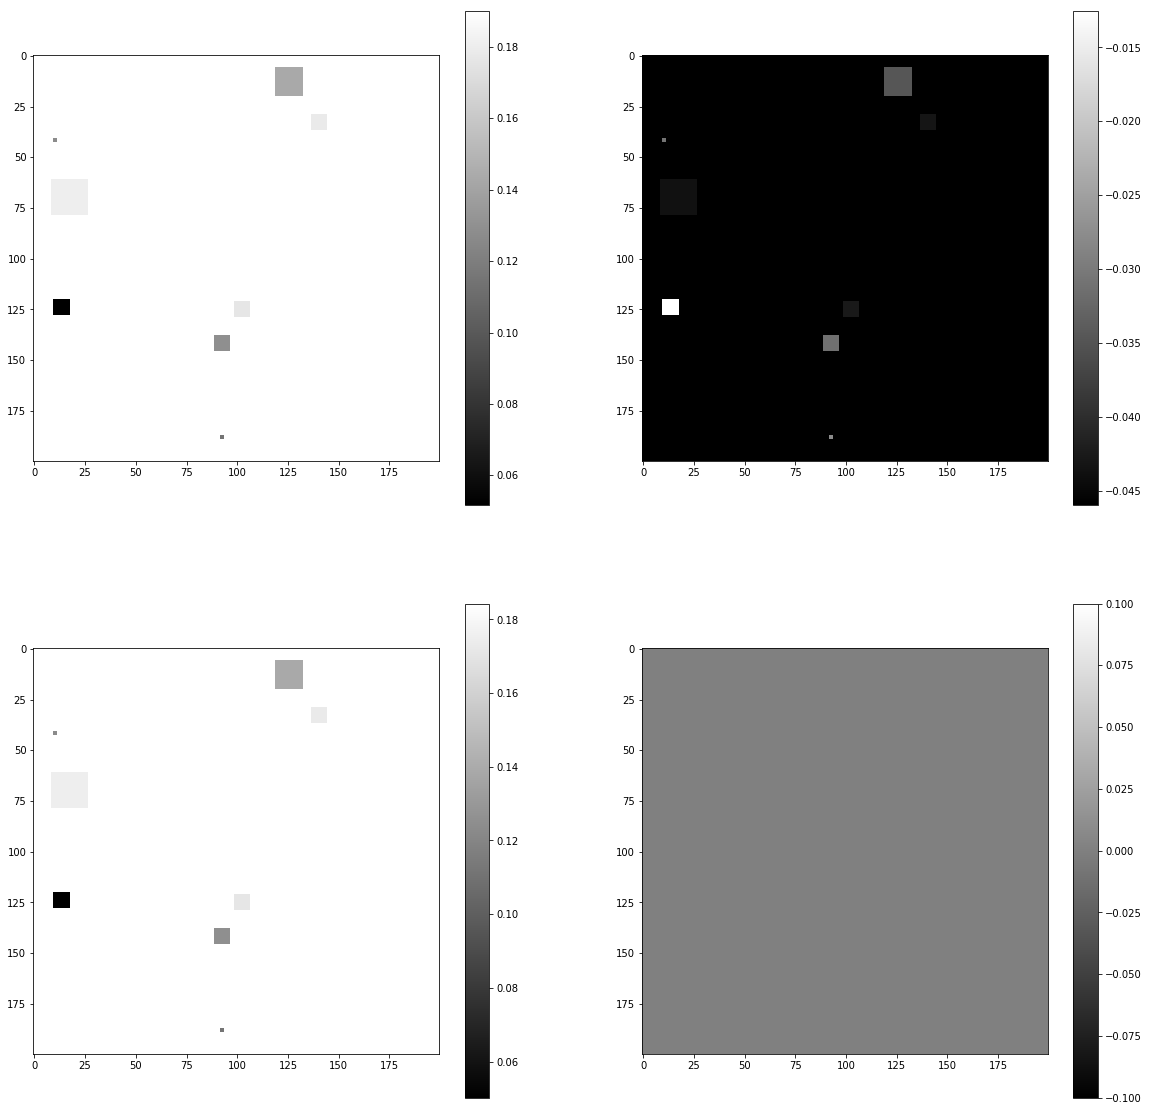

In [260]:
plotImages(I_full[:,:,0,0],I_full[:,:,1,0],I_full[:,:,2,0],I_full[:,:,3,0])
plotImages(A_img[:,:,3,0],A_img[:,:,3,1],A_img[:,:,3,2],A_img[:,:,3,3])

In [213]:
a = np.eye(2*3*4)
a.shape = (2*3, 4, 2, 3, 4)
print(a.shape)
b = np.random.randn(2*3, 4)
print(b.shape)
x = np.linalg.tensorsolve(a, b)
x.shape

np.allclose(np.tensordot(a, x, axes=3), b)

(6, 4, 2, 3, 4)
(6, 4)


True

In [261]:
A_img_inv = np.linalg.pinv(A_img)

In [263]:
A_img_inv.shape

(200, 200, 4, 4)

In [264]:
A_img_inv[0,0,:,:]

array([[ 1.11212001e+00,  1.03479641e+00,  1.25655991e+00,
         1.27305024e+00],
       [ 2.27161392e+00, -4.24162153e-01, -2.09505364e+00,
        -5.21822194e-01],
       [ 4.74090087e-01, -2.50505513e+00,  2.34830896e-03,
         2.34430644e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [268]:
A_img_inv @ I_full[:,:,:,0]

ValueError: shapes (200,200,4,4) and (200,200,4) not aligned: 4 (dim 3) != 200 (dim 1)

In [266]:
I_full.shape

(200, 200, 4, 11)

In [269]:
A*S_unp

matrix([[0.25868915],
        [0.22712713],
        [0.18713274],
        [0.19019893]])